In [284]:
import numpy as np
import scipy as sp
from scipy import stats
import math
import matplotlib.pyplot as plt
import allantools as al

In [30]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

In [367]:
#make laserdets be an array of detunings which are accurate during both pulse and dark time
#ie if laserdets is 0, then the pulse detungins and dark time detunings are both 0, the light shift is taken care of
#each point in laserdets corresponds to a detuning with time steps of 10 ms?

dt = 1e-3
psi0 = psi(1.0, 0.0)
t1 = 26e-3  #79/3 and 32.5           #first pi/2 pulse
t2 = 26e-3  #32.5e-3                            #second pi/2 pulse
Omega01 = np.pi/(2.*t1)
Omega02 = np.pi/(2.*t2)
T = 150e-3              #ramsey dark time
n = int((t1 + t2 + T)/dt)   #number of points timepoints in one Ramsey sequence 
npulse1 = int(t1/dt)
npulse2 = int(t2/dt)
ndark = int(T/dt)

tprep = 74e-3 # 73.5          #down time between end of one ramsey and the start of the next
nprep = int(tprep/dt)

trabi = 2*t1 #44e-3          #duration of rabi pulse
Omega0rabi = np.pi/trabi
nrabi = int(trabi/dt)
deltaRabi = 2.0*np.pi*13.*3./4.
lightshift = 200

N = 12*nprep + 4*nrabi + 8*n    #number of laser points in one interrogation run               

def RabiR(laserdets):
    delp = 2.*np.pi*np.average(laserdets) + 2.*np.pi*lightshift
    return rhoee(pulse(trabi, Omega0rabi, delp + deltaRabi, 0)@psi0)

def RabiL(laserdets):
    delp = 2.*np.pi*np.average(laserdets) + 2.*np.pi*lightshift
    return rhoee(pulse(trabi, Omega0rabi, delp - deltaRabi, 0)@psi0)

def RamseyR(aom, aomRab, laserdets):
    delp1 = 2.*np.pi*(lightshift + aomRab + np.average(laserdets[0:npulse1]))
    deld = 2.*np.pi*(aom + np.average(laserdets[npulse1:npulse1+ndark]))
    delp2 = 2.*np.pi*(lightshift + aomRab + np.average(laserdets[npulse1+ndark:]))
    return rhoee(pulse(t2, Omega02, delp2, 0)@pulse(T,0,deld,np.pi/2)@pulse(t1, Omega01, delp1, 0)@psi0)

def RamseyL(aom, aomRab, laserdets):
    delp1 = 2.*np.pi*(lightshift + aomRab + np.average(laserdets[0:npulse1]))
    deld = 2.*np.pi*(aom + np.average(laserdets[npulse1:npulse1+ndark]))
    delp2 = 2.*np.pi*(lightshift + aomRab + np.average(laserdets[npulse1+ndark:]))
    return rhoee(pulse(t2, Omega02, delp2, 0)@pulse(T,0,deld,-np.pi/2)@pulse(t1, Omega01, delp1, 0)@psi0)

def interrogate(aom1, aom2, aomRab, Laserdets):
    rabLa=np.random.binomial(1,RabiL(aomRab + Laserdets[nprep:nprep+nrabi]))
    l1a = np.random.binomial(1,RamseyL(aom1, aomRab, Laserdets[2*nprep+nrabi  :    2*nprep+nrabi+n]))
    l2a = np.random.binomial(1,RamseyL(aom2, aomRab, Laserdets[3*nprep+nrabi+n   : 3*nprep+nrabi+2*n]))
    rabRa=np.random.binomial(1,RabiR(aomRab + Laserdets[4*nprep+nrabi+2*n : 4*nprep+2*nrabi+2*n]))
    r1a = np.random.binomial(1,RamseyR(aom1, aomRab, Laserdets[5*nprep+2*nrabi+2*n : 5*nprep+2*nrabi+3*n]))
    r2a = np.random.binomial(1,RamseyR(aom2, aomRab, Laserdets[6*nprep+2*nrabi+3*n : 6*nprep+2*nrabi+4*n]))
    
    rabLb=np.random.binomial(1,RabiL(aomRab + Laserdets[7*nprep+2*nrabi+4*n : 7*nprep+3*nrabi+4*n]))
    l1b = np.random.binomial(1,RamseyL(aom1, aomRab, Laserdets[8*nprep+3*nrabi+4*n : 8*nprep+3*nrabi+5*n]))
    l2b = np.random.binomial(1,RamseyL(aom2, aomRab, Laserdets[9*nprep+3*nrabi+5*n : 9*nprep+3*nrabi+6*n]))
    rabRb=np.random.binomial(1,RabiR(aomRab + Laserdets[10*nprep+3*nrabi+6*n : 10*nprep+4*nrabi+6*n]))
    r1b = np.random.binomial(1,RamseyR(aom1, aomRab, Laserdets[11*nprep+4*nrabi+6*n : 11*nprep+4*nrabi+7*n]))
    r2b = np.random.binomial(1,RamseyR(aom2, aomRab, Laserdets[12*nprep+4*nrabi+7*n : 12*nprep+4*nrabi+8*n]))
    return [r1a+r1b-(l1a+l1b), r2a+r2b-(l2a+l2b), rabRa+rabRb-(rabLa+rabLb)] 

def interrogate2(aom1, aom2, aomRab, Laserdets):
    rabLa=np.random.binomial(1,RabiL(aomRab + Laserdets[nprep:nprep+nrabi]))
    l1a = np.random.binomial(1,RamseyL(aom1, aomRab, Laserdets[2*nprep+nrabi  :    2*nprep+nrabi+n]))
    l2a = np.random.binomial(1,RamseyL(aom2, aomRab, Laserdets[3*nprep+nrabi+n   : 3*nprep+nrabi+2*n]))
    rabRa=np.random.binomial(1,RabiR(aomRab + Laserdets[4*nprep+nrabi+2*n : 4*nprep+2*nrabi+2*n]))
    r1a = np.random.binomial(1,RamseyR(aom1, aomRab, Laserdets[5*nprep+2*nrabi+2*n : 5*nprep+2*nrabi+3*n]))
    r2a = np.random.binomial(1,RamseyR(aom2, aomRab, Laserdets[6*nprep+2*nrabi+3*n : 6*nprep+2*nrabi+4*n]))
    
    rabRb=np.random.binomial(1,RabiR(aomRab + Laserdets[7*nprep+2*nrabi+4*n : 7*nprep+3*nrabi+4*n]))
    l1b = np.random.binomial(1,RamseyL(aom1, aomRab, Laserdets[8*nprep+3*nrabi+4*n : 8*nprep+3*nrabi+5*n]))
    l2b = np.random.binomial(1,RamseyL(aom2, aomRab, Laserdets[9*nprep+3*nrabi+5*n : 9*nprep+3*nrabi+6*n]))
    rabLb=np.random.binomial(1,RabiL(aomRab + Laserdets[10*nprep+3*nrabi+6*n : 10*nprep+4*nrabi+6*n]))
    r1b = np.random.binomial(1,RamseyR(aom1, aomRab, Laserdets[11*nprep+4*nrabi+6*n : 11*nprep+4*nrabi+7*n]))
    r2b = np.random.binomial(1,RamseyR(aom2, aomRab, Laserdets[12*nprep+4*nrabi+7*n : 12*nprep+4*nrabi+8*n]))
    return [r1a+r1b-(l1a+l1b), r2a+r2b-(l2a+l2b), rabRa+rabRb-(rabLa+rabLb)] 

#the result of the interrogation is an integer from -2,2 for ramsey 1 and ramsey 2
# -2 corresponds to both excitations succesful on the left and none on the right
# 0 corresponds to equal excitations on left and right
# +2 corresponds to both excitations successful on the right and none on the left

gain = -13*3/4/180           #amount to step AOM by in Hz if interrogation returns 1
rabGain = 13*3/4/30

def run(laserpts):
    [r1,r2,rab] = interrogate2(0, 0, -lightshift, laserpts[0:N])
    aom1[0] = gain*r1
    aom2[0] = gain*r2
    aomRab[0] = rabGain*rab - lightshift
    for ii in range(1, runs):
        if ii%100==0:print(ii, end=" ")
        [r1,r2,rab] = interrogate2(aom1[ii-1], aom2[ii-1], aomRab[ii-1], laserpts[(ii-1)*N:ii*N])
        aom1[ii] = gain*r1 + aom1[ii-1]
        aom2[ii] = gain*r2 + aom2[ii-1]
        aomRab[ii] = rabGain*rab + aomRab[ii-1]

In [370]:
runs = 100000           #number of interogation sequences to run
#laser = np.zeros(N*runs)  #frequency of laser (in Hz) measured every dt seconds 
aom1 = np.zeros(runs)       #frequency of AOM for servo 1, stored for every interogation sequence
aom2 = np.zeros(runs)
aomRab = np.zeros(runs)

driftrate = 20 #(Hz/hour)
ffinal = driftrate*(N*runs*dt)/3600
#print(ffinal)
laser = np.linspace(0, ffinal, N*runs)
laserplot = np.linspace(0, ffinal, runs)

ts = np.linspace(0, dt*N*runs, N*runs)
taoms = np.linspace(0, dt*N*runs, runs)
run(laser)

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 1850

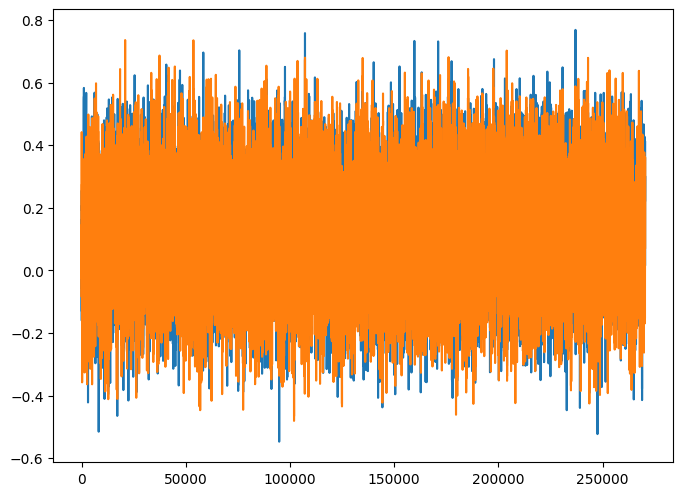

Offset between Ramsey 1 and Ramsey 2 is 0.0024  Hz
Uncertainty is  0.004  Hz

AOM 1 Average:  0.117 +/-  0.156 Hz
AOM 2 Average:  0.115 +/-  0.156 Hz


In [371]:
e3 = 642121496772645.10

plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts, laser)
plt.plot(taoms, aom1+laserplot)
plt.plot(taoms, aom2+laserplot)
plt.show()
print("Offset between Ramsey 1 and Ramsey 2 is", np.round(np.average(aom1-aom2), 4), " Hz")
print("Uncertainty is ", np.round(e3*3.1e-15/np.sqrt(ts[-1]),3), " Hz")

#print("Uncertainty is ", np.round(np.std(aom1-aom2),4), " Hz")
print("")
print("AOM 1 Average: ", np.round(np.average(aom1)+np.average(laser),3), r'+/- ', np.round(np.std(aom1+laserplot), 3), "Hz")
print("AOM 2 Average: ", np.round(np.average(aom2)+np.average(laser),3), r'+/- ', np.round(np.std(aom2+laserplot), 3), "Hz")

In [374]:
(n+nprep)*dt*driftrate/3600

0.0015277777777777779

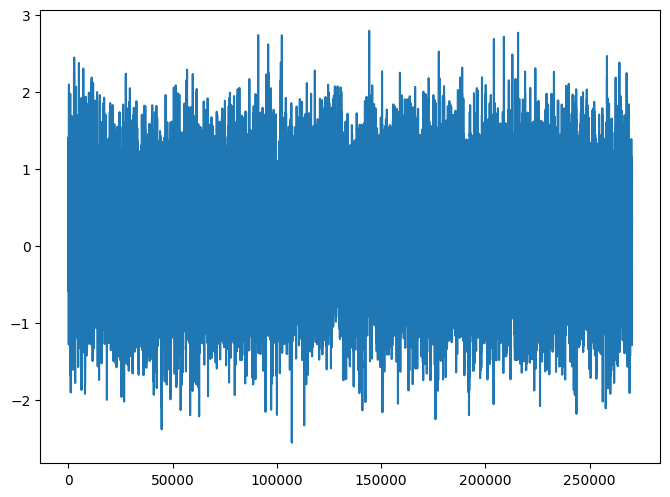

Rabi Offset:  0.14499911108180186


In [373]:
plt.figure(figsize=(8,6), dpi=100)
#plt.plot(ts, laser)
plt.plot(taoms, aomRab+lightshift+laserplot)
plt.show()
print("Rabi Offset: ", np.average(aomRab)+lightshift+np.average(laserplot))

In [322]:
rabGain

0.325

In [327]:
N*dt/2*driftrate/3600

0.007511111111111112

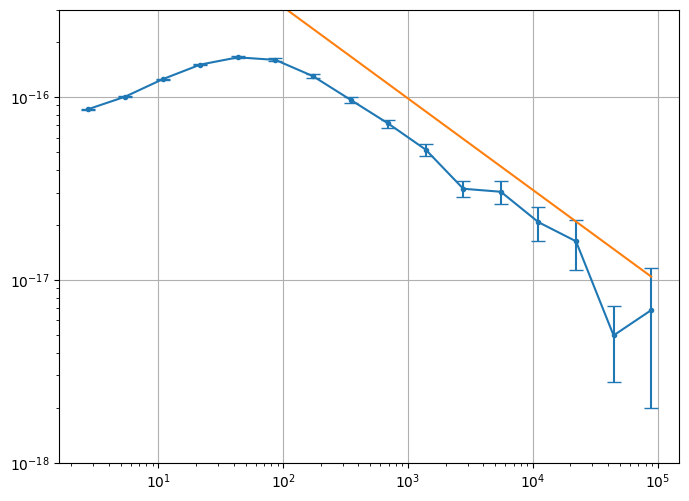

In [289]:
rate = 1/(taoms[1]-taoms[0])

taus, adev, adeverrs,_ = al.adev(aom1-aom2, rate, data_type="freq")
plt.figure(figsize=(8,6), dpi=100)

plt.errorbar(taus, adev/e3, yerr=adeverrs/e3, fmt='.', capsize=5, color="tab:blue")
plt.loglog(taus, adev/e3)
plt.plot(taus, 3.1e-15/np.sqrt(taus))
plt.ylim([1e-18, 3e-16])
plt.grid()

In [356]:
N*dt*driftrate/3600

0.015022222222222223